In [1]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np
from src.dataset.dataset import SimpleIterDataset, EventDataset
from src.utils.utils import to_filelist
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rc('font', size=13)
from src.plotting.plot_event import plot_event_comparison
from src.dataset.functions_data import concat_events

In [2]:

def remove_from_list(lst):
    out = []
    for item in lst:
        if item in ["hgcal", "data.txt", "test_file.root"]:
            continue
        out.append(item)
    return out

#path = "/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak"
def get_iter(path_to_root_file):
    datasets = [path_to_root_file]
    class Args:
        def __init__(self):
            self.data_train = datasets
            self.data_val = datasets
            #self.data_train = files_train
            self.data_config = '/work/gkrzmanc/jetclustering/code/config_files/config_jets_1.yaml'
            self.extra_selection = None
            self.train_val_split = 1
            self.data_fraction = 1
            self.file_fraction = 1
            self.fetch_by_files = False
            self.fetch_step = 1

            self.steps_per_epoch = None
            self.in_memory = False
            self.local_rank = None
            self.copy_inputs = False
            self.no_remake_weights = False
            self.batch_size = 10
            self.num_workers = 0
            self.demo = False
            self.laplace = False
            self.diffs = False
            self.class_edges = False

    args = Args()
    train_range = (0, args.train_val_split)
    train_file_dict, train_files = to_filelist(args, 'train')
    train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                                   extra_selection=args.extra_selection,
                                   remake_weights=True,
                                   load_range_and_fraction=(train_range, args.data_fraction),
                                   file_fraction=args.file_fraction,
                                   fetch_by_files=args.fetch_by_files,
                                   fetch_step=args.fetch_step,
                                   infinity_mode=False,
                                   in_memory=args.in_memory,
                                   async_load=False,
                                   name='train', jets=True)

    iterator = iter(train_data)

    return iterator


In [3]:
dataset = get_iter("/pnfs/psi.ch/cms/trivcat/store/user/gkrzmanc/jetclustering/sim/out3.root")

['/pnfs/psi.ch/cms/trivcat/store/user/gkrzmanc/jetclustering/sim/out3.root']
=== Restarting DataIter train, seed=None ===


In [21]:
evt = next(dataset)

In [22]:
labels = ["scounting PFCands", "genParticles", "parton level"]
colors = ["gray", "blue", "red"]
classes = ["pfcands", "final_gen_particles", "final_parton_level_particles"]


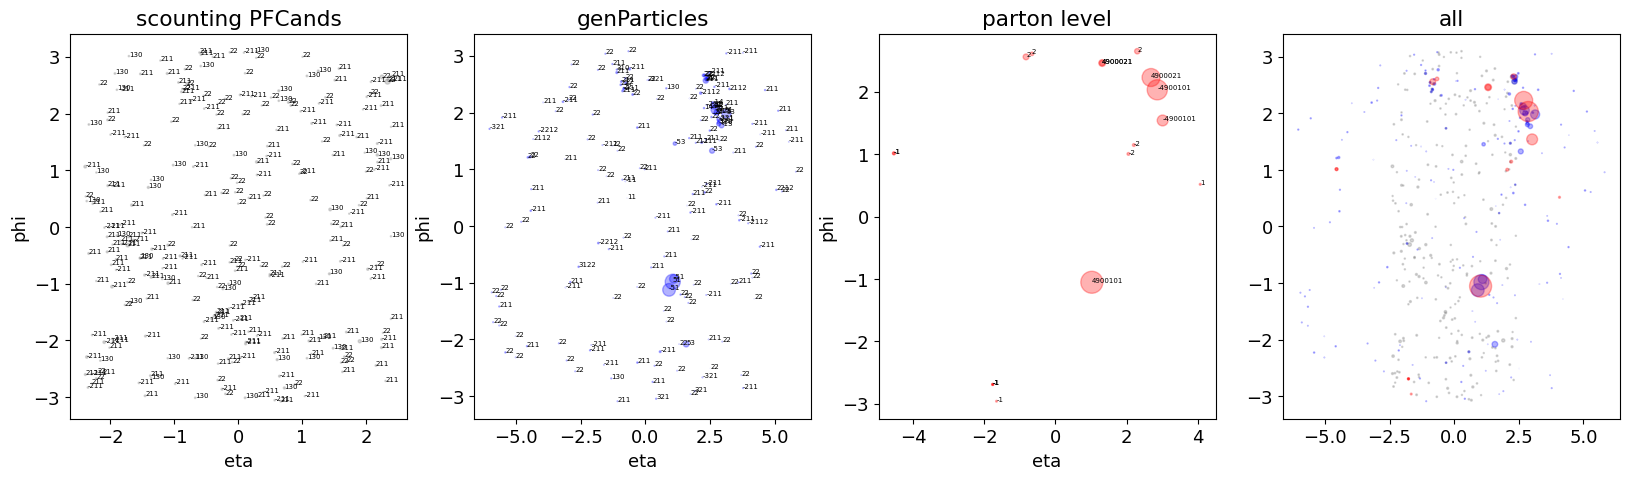

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(3):
    pt = getattr(evt, classes[i]).pt
    eta = getattr(evt, classes[i]).eta
    phi = getattr(evt, classes[i]).phi
    ax[i].scatter(eta, phi, s=pt, color=colors[i], alpha=0.3)
    ax[i].set_title(labels[i])
    ax[i].set_xlabel("eta")
    ax[i].set_ylabel("phi")
    ax[-1].scatter(eta, phi, s=pt, color=colors[i], alpha=0.3, label=labels[i])
    # put PID where the circles are
    for j, txt in enumerate(getattr(evt, classes[i]).pid):
        ax[i].annotate(txt.int().item(), (eta[j], phi[j]), size=5)
ax[-1].set_title("all")
fig.savefig("/work/gkrzmanc/jetclustering/results/event_with_PIDs.pdf")
fig.show()

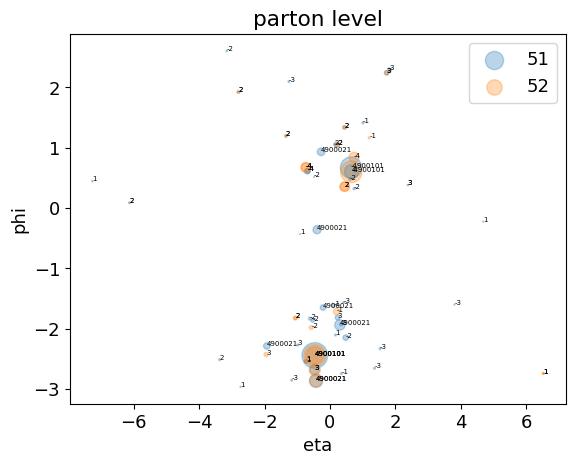

In [19]:
fig, ax = plt.subplots()
# plot status 51 and 52 with differnt colors
status = evt.final_parton_level_particles.status.int()
# also keep the plot style as from above
pt = evt.final_parton_level_particles.pt
eta = evt.final_parton_level_particles.eta
phi = evt.final_parton_level_particles.phi

statuses = torch.unique(status)
for s in statuses:
    status_filt = status == s
    ax.scatter(eta[status_filt], phi[status_filt], s=pt[status_filt], alpha=0.3, label=s.item())

ax.set_title("parton level")
ax.set_xlabel("eta")
ax.legend()
ax.set_ylabel("phi")
# put PID where the circles are
for j, txt in enumerate(evt.final_parton_level_particles.pid):
    ax.annotate(txt.int().item(), (eta[j], phi[j]), size=5)
fig.show()
fig.savefig("/work/gkrzmanc/jetclustering/results/event_with_PIDs_parton_level_status.pdf")